# Transfer Learning in PyTorch

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), #randomly crops a
        transforms.RandomHorizontalFlip(), # flips either ways on a horizontal view
        transforms.ToTensor(),# converts in tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and s.d. for each channel
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']} # defines train and test for different datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']} # similarly defines dataloaders for train and test 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

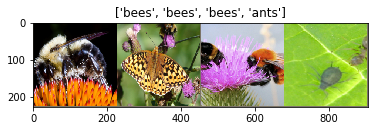

In [3]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
    # Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

## loading Resnet-18 pretrained model

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr = 1e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Training and evaluation

In [7]:
%%time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.6410 Acc: 0.5943
val Loss: 0.4233 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.5015 Acc: 0.7459
val Loss: 0.3117 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4585 Acc: 0.7787
val Loss: 0.2565 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4347 Acc: 0.7910
val Loss: 0.2360 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3868 Acc: 0.8320
val Loss: 0.2275 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3943 Acc: 0.8320
val Loss: 0.2061 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3315 Acc: 0.8689
val Loss: 0.2049 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3159 Acc: 0.8525
val Loss: 0.1958 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3643 Acc: 0.8279
val Loss: 0.1928 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2890 Acc: 0.8811
val Loss: 0.2186 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3077 Acc: 0.8811
val Loss: 0.1871 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2627 Acc: 0.9139
val Loss: 0.1948 Acc: 0.9412

Ep

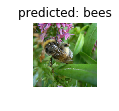

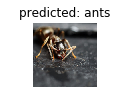

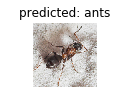

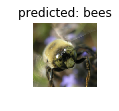

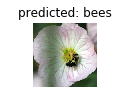

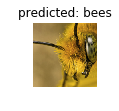

In [8]:
visualize_model(model_ft)

## Treating ConvNet as a Feature Extractor

In previous code we propogated error to the whole net but here we freeze the pretrained net and just train the new added layer.

In [9]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr = 1e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [10]:
%%time
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8030 Acc: 0.5164
val Loss: 0.6793 Acc: 0.5817

Epoch 1/24
----------
train Loss: 0.7493 Acc: 0.5287
val Loss: 0.6221 Acc: 0.6275

Epoch 2/24
----------
train Loss: 0.7036 Acc: 0.5287
val Loss: 0.6062 Acc: 0.6667

Epoch 3/24
----------
train Loss: 0.6773 Acc: 0.5451
val Loss: 0.5824 Acc: 0.7451

Epoch 4/24
----------
train Loss: 0.6515 Acc: 0.6025
val Loss: 0.5854 Acc: 0.7386

Epoch 5/24
----------
train Loss: 0.6496 Acc: 0.6025
val Loss: 0.5783 Acc: 0.7582

Epoch 6/24
----------
train Loss: 0.6683 Acc: 0.5656
val Loss: 0.5913 Acc: 0.7190

Epoch 7/24
----------
train Loss: 0.6564 Acc: 0.6107
val Loss: 0.5810 Acc: 0.7320

Epoch 8/24
----------
train Loss: 0.6607 Acc: 0.5861
val Loss: 0.6004 Acc: 0.7582

Epoch 9/24
----------
train Loss: 0.6723 Acc: 0.5943
val Loss: 0.5729 Acc: 0.7647

Epoch 10/24
----------
train Loss: 0.6299 Acc: 0.6803
val Loss: 0.5676 Acc: 0.7647

Epoch 11/24
----------
train Loss: 0.6477 Acc: 0.6311
val Loss: 0.5823 Acc: 0.7320

Ep

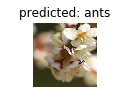

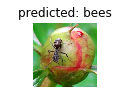

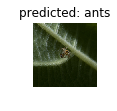

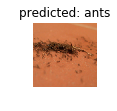

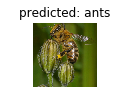

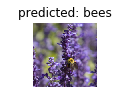

In [11]:
visualize_model(model_conv)